
# 🌌 IndraQuantum: Complex Embedding & Graph Attention Analysis

This notebook demonstrates the inner workings of the **IndraQuantum** architecture, specifically focusing on:

1.  **Complex-Valued Embeddings**: Visualizing Magnitude and Phase.
2.  **Appended Graph Topology**: How tokens, sentences, and paragraphs are structured.
3.  **Complex Edge-Biased Attention**: How the model "attends" using quantum interference and decoupled biases (Local Window + Hierarchy).

We will use a small sample text to visualize these concepts.


In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath('..'))

from indra.models.quantum_graph import IndraQuantumGraph, ComplexGraphAttentionLayer
from indra.graph.builder import TextGraphBuilder
from transformers import AutoTokenizer

# Setup plotting style
plt.style.use('dark_background')
sns.set_theme(style="darkgrid")



## 1. Model & Graph Builder Setup

We initialize a small `IndraQuantumGraph` model and the `TextGraphBuilder`.


In [9]:

# Initialize Tokenizer and Builder
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0")
builder = TextGraphBuilder(tokenizer, max_seq_len=64)

# Initialize Model
vocab_size = 32002 # 32000 + SENT + PARA
d_model = 64
n_heads = 4
model = IndraQuantumGraph(vocab_size, d_model, n_layers=2, n_heads=n_heads)
model.eval()

print(f"Model initialized with d_model={d_model}, n_heads={n_heads}")


Model initialized with d_model=64, n_heads=4



## 2. Processing Text into Quantum Graph

We process a sample text containing multiple sentences. The `TextGraphBuilder` will:
1.  Tokenize the text.
2.  Append **Sentence** and **Paragraph** nodes.
3.  Construct the **Graph Mask** (Adjacency Matrix) with edge types.

**Topology:** `[ Tokens... | Sentences... | Paragraphs... ]`


In [10]:
text = 'The quantum cat is alive. It is also dead. This is a paradox.'

graph = builder.build_graph(text)

input_ids = graph['input_ids'].unsqueeze(0)
node_types = graph['node_types'].unsqueeze(0)
graph_mask = graph['graph_mask'].unsqueeze(0)

print(f'Sequence Length: {graph["seq_len"]}')
print(f'Input IDs shape: {input_ids.shape}')

# Decode tokens to see the structure
decoded = tokenizer.convert_ids_to_tokens(input_ids[0])
# Replace special IDs with readable labels
readable_tokens = []
for i, token_id in enumerate(input_ids[0]):
    if token_id == builder.SENT_TOKEN_ID:
        readable_tokens.append('<SENT>')
    elif token_id == builder.PARA_TOKEN_ID:
        readable_tokens.append('<PARA>')
    else:
        readable_tokens.append(tokenizer.decode([token_id]).strip())

print('Graph Structure (Tokens + Structural Nodes):')
print(readable_tokens)


Sequence Length: 22
Input IDs shape: torch.Size([1, 22])
Graph Structure (Tokens + Structural Nodes):
['The', 'quantum', 'cat', 'is', 'alive', '.', 'It', 'is', 'also', 'dead', '.', 'This', 'is', 'a', 'par', 'ado', 'x', '.', '<PARA>', '<SENT>', '<SENT>', '<SENT>']



## 3. Visualizing Complex Embeddings

In IndraQuantum, embeddings are complex numbers $z = r e^{i\theta}$.
*   **Magnitude ($r$):** Represents semantic strength.
*   **Phase ($	heta$):** Represents structural/contextual state.

Let's visualize the initial embeddings for our sequence.


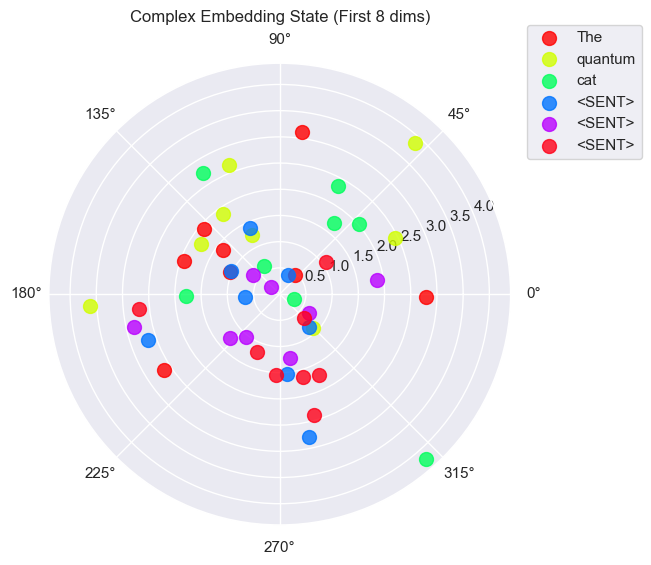

In [11]:

# Get Embeddings
with torch.no_grad():
    # Token Embeddings
    x = model.token_embedding(input_ids)
    
    # Add Type Embeddings
    t_emb = model.type_embedding(node_types)
    x = x + t_emb
    
    # Position Embeddings
    positions = torch.arange(input_ids.size(1), device=input_ids.device).unsqueeze(0)
    pos_emb = model.position_embedding(positions)
    x = x + pos_emb

# Split into Real and Imaginary
x_real, x_imag = torch.chunk(x, 2, dim=-1)

# Compute Magnitude and Phase
magnitude = torch.sqrt(x_real**2 + x_imag**2)
phase = torch.atan2(x_imag, x_real)

# Visualize for a few tokens
tokens_to_plot = [0, 1, 2, -3, -2, -1] # First few words and last structural nodes
labels = [readable_tokens[i] for i in tokens_to_plot]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='polar')

colors = plt.cm.hsv(np.linspace(0, 1, len(tokens_to_plot)))

for i, idx in enumerate(tokens_to_plot):
    # Plot first 8 dimensions for clarity
    r = magnitude[0, idx, :8].numpy()
    theta = phase[0, idx, :8].numpy()
    ax.scatter(theta, r, c=[colors[i]], label=labels[i], s=100, alpha=0.8)

ax.set_title("Complex Embedding State (First 8 dims)", va='bottom')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()



## 4. Complex Edge-Biased Attention Analysis

We will now inspect the attention mechanism inside the `ComplexGraphAttentionLayer`.
We want to see:
1.  **Local Window Bias:** How tokens attend to neighbors.
2.  **Hierarchy Bias:** How tokens attend to Sentence nodes.
3.  **Interference:** The resulting attention pattern.

We'll manually run the attention logic to extract the scores.


In [12]:

# Extract the first layer
layer = model.layers[0]

# Forward pass logic (manual extraction)
with torch.no_grad():
    batch_size, seq_len, _ = x.shape
    
    # 1. Project Q, K
    q = layer.q_proj(x)
    k = layer.k_proj(x)
    
    # Split Heads
    def split_heads(tensor):
        t_real, t_imag = torch.chunk(tensor, 2, dim=-1)
        t_real = t_real.view(batch_size, seq_len, layer.n_heads, layer.head_dim).transpose(1, 2)
        t_imag = t_imag.view(batch_size, seq_len, layer.n_heads, layer.head_dim).transpose(1, 2)
        return t_real, t_imag
        
    q_r, q_i = split_heads(q)
    k_r, k_i = split_heads(k)
    
    # 2. Compute Quantum Interference Attention: |Q* K|^2
    k_r_t = k_r.transpose(-2, -1)
    k_i_t = k_i.transpose(-2, -1)
    
    ac_real = torch.matmul(q_r, k_r_t) + torch.matmul(q_i, k_i_t)
    ac_imag = torch.matmul(q_r, k_i_t) - torch.matmul(q_i, k_r_t)
    
    attn_scores = (ac_real**2 + ac_imag**2) / math.sqrt(layer.head_dim)
    
    # 3. Add Biases
    # Local Window Bias
    positions = torch.arange(seq_len)
    dist = (positions.unsqueeze(0) - positions.unsqueeze(1)).abs()
    local_mask = (dist <= layer.local_window).float().unsqueeze(0).unsqueeze(0)
    local_bias = layer.bias_weights[:, 0].view(1, layer.n_heads, 1, 1) * local_mask
    
    # Hierarchy Bias
    hierarchy_mask = (graph_mask > 1).float().unsqueeze(1)
    hierarchy_bias = layer.bias_weights[:, 1].view(1, layer.n_heads, 1, 1) * hierarchy_mask
    
    final_scores = attn_scores + local_bias + hierarchy_bias
    attn_probs = F.softmax(final_scores, dim=-1)

print("Attention Probabilities Shape:", attn_probs.shape)


Attention Probabilities Shape: torch.Size([1, 4, 22, 22])



### Visualizing the Attention Map

We visualize the attention map for **Head 0**.
Look for:
*   **Diagonal Band:** The Local Window bias.
*   **Blocks/Points at the End:** The Structural Nodes (Sentences/Para) attending to their tokens.


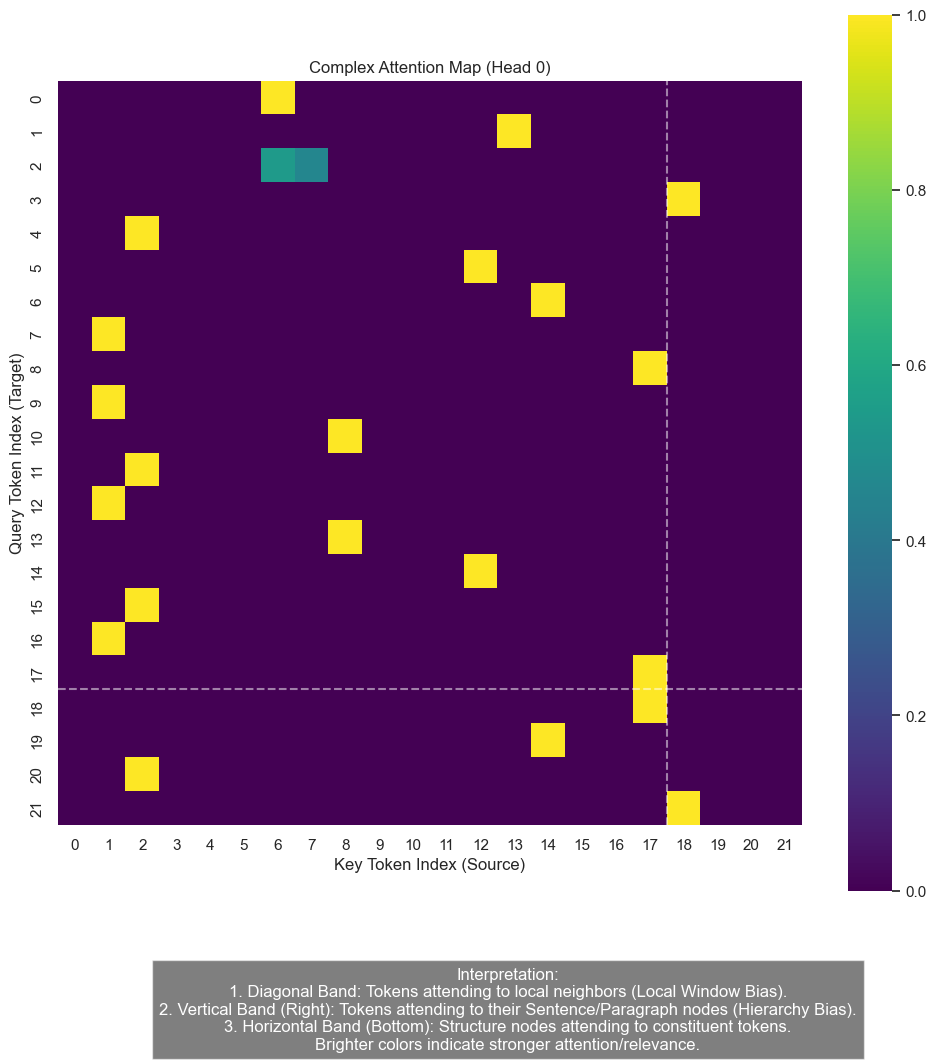

In [13]:

# Plot Attention Map for Head 0
head_idx = 0
attn_map = attn_probs[0, head_idx].numpy()

plt.figure(figsize=(12, 12)) # Increased height for text
sns.heatmap(attn_map, cmap="viridis", square=True)
plt.title(f"Complex Attention Map (Head {head_idx})")
plt.xlabel("Key Token Index (Source)")
plt.ylabel("Query Token Index (Target)")

# Add lines to separate Tokens from Structure
num_tokens = len([t for t in readable_tokens if t not in ["<SENT>", "<PARA>"]])
plt.axvline(x=num_tokens, color='white', linestyle='--', alpha=0.5)
plt.axhline(y=num_tokens, color='white', linestyle='--', alpha=0.5)
plt.text(num_tokens/2, -1, "Tokens (Words)", ha='center', color='white', fontsize=10)
plt.text(num_tokens + 2, -1, "Structure\n(Sent/Para)", ha='center', color='white', fontsize=10)

# Add Explanatory Text
explanation = (
    "Interpretation:\n"
    "1. Diagonal Band: Tokens attending to local neighbors (Local Window Bias).\n"
    "2. Vertical Band (Right): Tokens attending to their Sentence/Paragraph nodes (Hierarchy Bias).\n"
    "3. Horizontal Band (Bottom): Structure nodes attending to constituent tokens.\n"
    "Brighter colors indicate stronger attention/relevance."
)
plt.figtext(0.5, 0.02, explanation, wrap=True, horizontalalignment='center', fontsize=12, bbox=dict(facecolor='black', alpha=0.5, pad=5), color='white')

plt.subplots_adjust(bottom=0.15) # Make room for text
plt.show()



## 5. Relevance Analysis

How does a token "maintain relevance"?
By attending to both its **Local Neighbors** (immediate context) and its **Sentence Node** (global context).

Let's pick a word in the middle of a sentence and see its attention distribution.


Analyzing Attention for Token: 'cat'


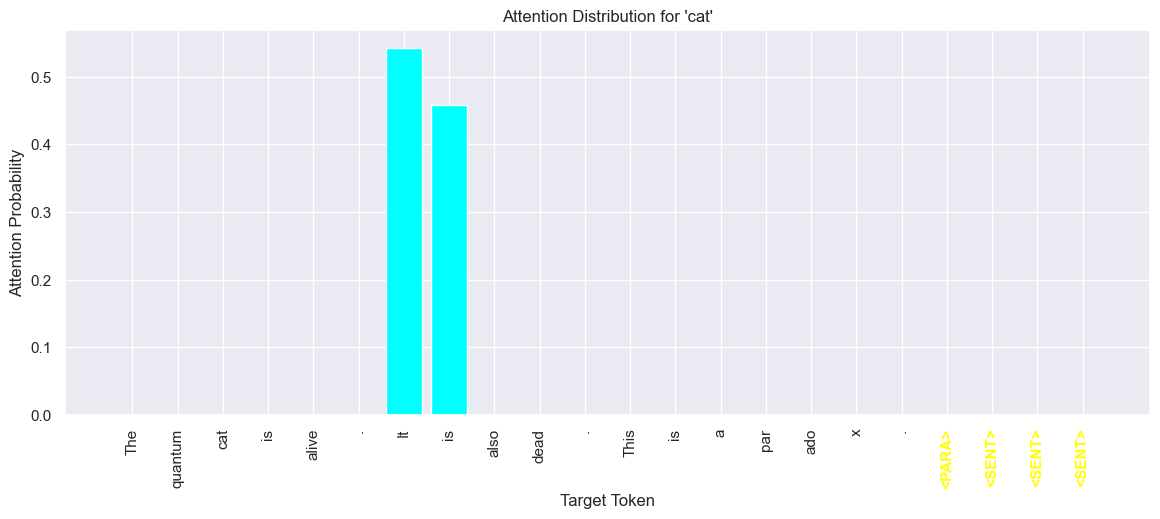

In [14]:

# Pick a token index (e.g., "cat")
target_token_idx = 2 # "cat"
print(f"Analyzing Attention for Token: '{readable_tokens[target_token_idx]}'")

attn_dist = attn_probs[0, head_idx, target_token_idx, :].numpy()

# Plot Bar Chart
plt.figure(figsize=(14, 5))
plt.bar(range(len(readable_tokens)), attn_dist, color='cyan')
plt.xticks(range(len(readable_tokens)), readable_tokens, rotation=90)
plt.title(f"Attention Distribution for '{readable_tokens[target_token_idx]}'")
plt.xlabel("Target Token")
plt.ylabel("Attention Probability")

# Highlight Structural Nodes
for i, token in enumerate(readable_tokens):
    if token in ["<SENT>", "<PARA>"]:
        plt.gca().get_xticklabels()[i].set_color('yellow')
        plt.gca().get_xticklabels()[i].set_fontweight('bold')

plt.show()
